In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, ReLU, Input, LeakyReLU
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
SEQ_LEN = 10

X = np.load(f'AI/data/X_final_seq_{SEQ_LEN}.npy')
y = np.load(f'AI/data/y_final_seq_{SEQ_LEN}.npy')

# X = np.load(f'X_seq_{SEQ_LEN}.npy')
# y = np.load(f'y_seq_{SEQ_LEN}.npy')

In [4]:
one_hot_y = to_categorical(y)

In [5]:
X.shape, y.shape, one_hot_y.shape

((3871, 10, 132), (3871, 1), (3871, 9))

In [6]:
features_train, features_test_val, labels_train, labels_test_val = train_test_split(X, one_hot_y, test_size = 0.2, shuffle = True)

In [7]:
features_val, features_test, labels_val, labels_test = train_test_split(features_test_val, labels_test_val,
                                                                        test_size=0.5, shuffle=True)

In [8]:
features_train.shape, features_val.shape, features_test.shape

((3096, 10, 132), (387, 10, 132), (388, 10, 132))

In [9]:
# features_train = StandardScaler().fit(features_train)

# features_train = StandardScaler().transform(features_train)
# features_val = StandardScaler().transform(features_val)
# features_test = StandardScaler().transform(features_test)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((features_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((features_val, labels_val))
test_dataset = tf.data.Dataset.from_tensor_slices((features_test, labels_test))

train_dataset = train_dataset.cache()
val_dataset = val_dataset.cache()
test_dataset = test_dataset.cache()

train_dataset = train_dataset.shuffle(3500)  
val_dataset = val_dataset.shuffle(500)
test_dataset = test_dataset.shuffle(500)

train_dataset = train_dataset.batch(3096)
val_dataset = val_dataset.batch(387)
test_dataset = test_dataset.batch(128)

# train_dataset = train_dataset.prefetch(AUTOTUNE)
# val_dataset = val_dataset.prefetch(AUTOTUNE)
# test_dataset = test_dataset.prefetch(AUTOTUNE)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [12]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1, 1, 4)

In [14]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

In [15]:
def make_model():
    # lrelu = LeakyReLU(alpha=0.1)

    inputs = Input(shape=(X.shape[1], X.shape[2]))

    x = LSTM(128, activation='tanh', unroll=True, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(inputs)
    x = LSTM(128, activation='tanh', unroll=True, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)(x)
    x = LSTM(128, activation='tanh', unroll=True, dropout=0.5, recurrent_dropout=0.5, return_sequences=False)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)
    # x = BatchNormalization()(x)

    outputs = Dense(one_hot_y.shape[1], activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.summary()

    return model

In [16]:
lstm_model = make_model()

print("Model Created Successfully!")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 132)]         0         
                                                                 
 lstm (LSTM)                 (None, 10, 128)           133632    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 9)                 585   

In [17]:
rd_lr = ReduceLROnPlateau()
help(rd_lr)

Help on ReduceLROnPlateau in module keras.callbacks object:

class ReduceLROnPlateau(Callback)
 |  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0, **kwargs)
 |  
 |  Reduce learning rate when a metric has stopped improving.
 |  
 |  Models often benefit from reducing the learning rate by a factor
 |  of 2-10 once learning stagnates. This callback monitors a
 |  quantity and if no improvement is seen for a 'patience' number
 |  of epochs, the learning rate is reduced.
 |  
 |  Example:
 |  
 |  ```python
 |  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
 |                                patience=5, min_lr=0.001)
 |  model.fit(X_train, Y_train, callbacks=[reduce_lr])
 |  ```
 |  
 |  Args:
 |      monitor: quantity to be monitored.
 |      factor: factor by which the learning rate will be reduced.
 |        `new_lr = lr * factor`.
 |      patience: number of epochs with no improvement after whi

In [18]:
# lr = 1e-4

# def scheduler(epoch, lr):
#   if epoch < 300:
#     return lr
#   elif epoch < 1000:
#     return lr*0.1
#   else:
#     return lr *0.001
  
# optimizer = Adam(lr)

rd_lr = ReduceLROnPlateau(patience=100, factor=0.5, min_lr=0.00001)

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 1000, mode = 'min', restore_best_weights = True)

model_checkpoint_callback = ModelCheckpoint('AI/models/lstm_model_checkpoint_last.h5', verbose=1, monitor='val_loss', mode='min', save_best_only=True)

callbacks = [model_checkpoint_callback, early_stopping_callback]#, rd_lr]#, LearningRateScheduler(scheduler)]
 
lstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam' , metrics = ["accuracy"])

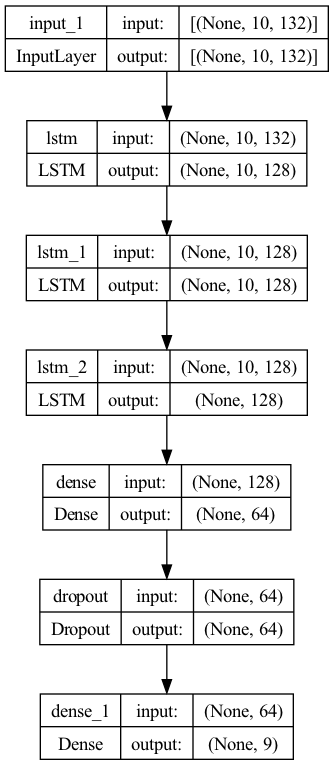

In [19]:
plot_model(lstm_model, to_file = 'images/lstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [20]:
lstm_model_training_history = lstm_model.fit(train_dataset,  epochs = 5000,
                                             shuffle = True, validation_data=val_dataset, callbacks = callbacks)

Epoch 1/5000


2023-06-19 12:53:20.948863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - ETA: 0s - loss: 2.2138 - accuracy: 0.1127
Epoch 1: val_loss improved from inf to 2.17822, saving model to lstm_model_checkpoint_last.h5
1/1 [==============================] - 20s 20s/step - loss: 2.2138 - accuracy: 0.1127 - val_loss: 2.1782 - val_accuracy: 0.2119
Epoch 2/5000
1/1 [==============================] - ETA: 0s - loss: 2.1862 - accuracy: 0.1499
Epoch 2: val_loss improved from 2.17822 to 2.16183, saving model to lstm_model_checkpoint_last.h5
1/1 [==============================] - 2s 2s/step - loss: 2.1862 - accuracy: 0.1499 - val_loss: 2.1618 - val_accuracy: 0.2067
Epoch 3/5000
1/1 [==============================] - ETA: 0s - loss: 2.1691 - accuracy: 0.1773
Epoch 3: val_loss improved from 2.16183 to 2.13855, saving model to lstm_model_checkpoint_last.h5
1/1 [==============================] - 1s 1s/step - loss: 2.1691 - accuracy: 0.1773 - val_loss: 2.1386 - val_accuracy: 0.2067
Epoch 4/5000
1/1 [==============================] - ETA: 0s -

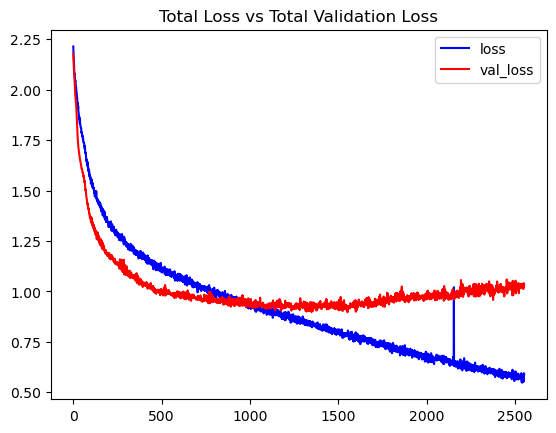

In [21]:
plot_metric(lstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

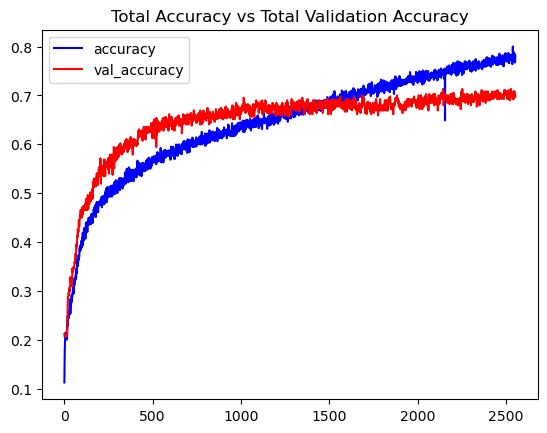

In [22]:
plot_metric(lstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [23]:
model_evaluation_history = lstm_model.evaluate(test_dataset)

4/4 [==============================] - 8s 2s/step - loss: 0.9981 - accuracy: 0.6675


In [24]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
model_file_name = f'AI/models/final_lstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

lstm_model.save(model_file_name)

In [25]:
X.shape

(3871, 10, 132)

In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns\

CLASSES_LIST = ['Fall Down',
 'Sit down',
 'Walking',
 'Lying Down',
 'Stand up',
 'Standing',
 'Sitting',
 'Chest Pain',
 'Coughing']

121/121 [==============================] - 19s 113ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86       556
         1.0       0.85      0.70      0.77       261
         2.0       0.81      0.77      0.79       930
         3.0       0.62      0.91      0.74       489
         4.0       0.92      0.81      0.86       410
         5.0       0.76      0.65      0.70       698
         6.0       0.69      0.72      0.70       432
         7.0       0.94      0.83      0.88        58
         8.0       0.81      0.92      0.86        37

    accuracy                           0.77      3871
   macro avg       0.81      0.80      0.80      3871
weighted avg       0.79      0.77      0.78      3871



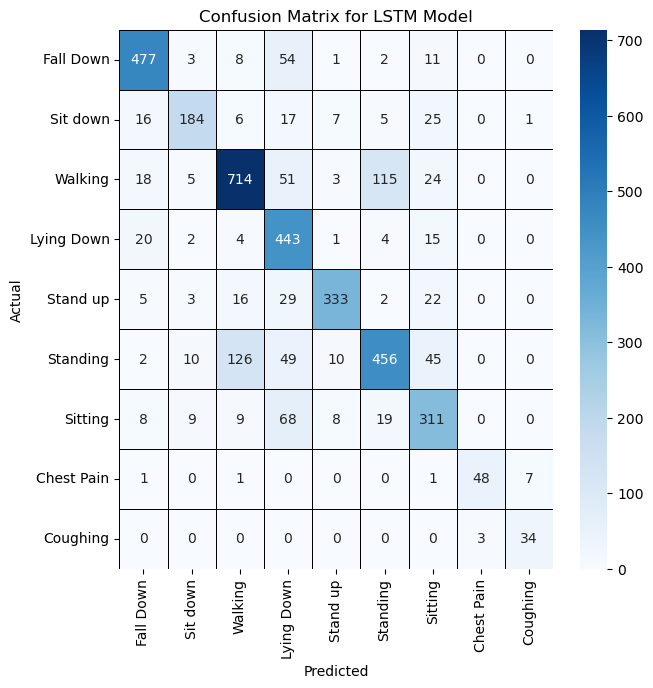

In [7]:
SEQ_LEN =10
model = tf.keras.saving.load_model('AI/models/final_lstm_model___Date_Time_2023_06_19__13_31_39___Loss_0.998094916343689___Accuracy_0.6675257682800293.h5')
X = np.load(f'AI/data/X_final_seq_{SEQ_LEN}.npy')
y = np.load(f'AI/data/y_final_seq_{SEQ_LEN}.npy')

pred = model.predict(X)
pred = np.argmax(pred, axis=1)

print(classification_report(y, pred))

plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix(y, pred), cmap='Blues', annot=True, linecolor='black', linewidth=0.5, fmt='')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')
plt.xticks(np.arange(9)+0.5, CLASSES_LIST, rotation=90)
plt.yticks(np.arange(9)+0.5, CLASSES_LIST, rotation=0)
plt.show()